Some of the Noise Models and their applications

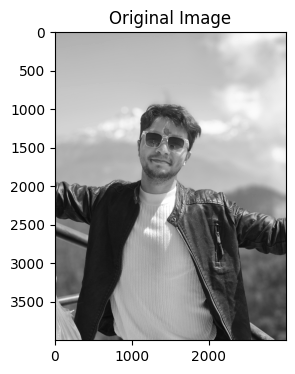

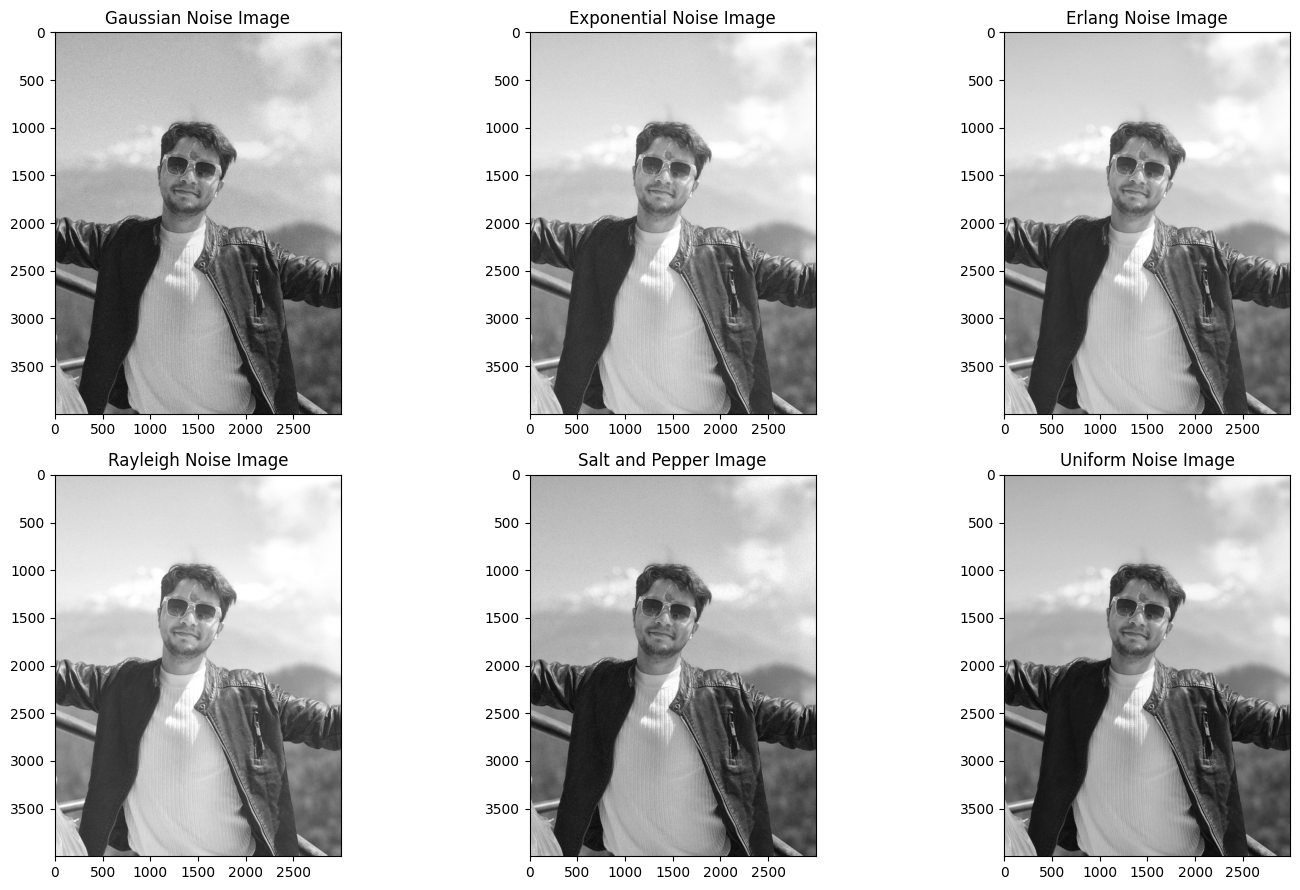

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_noise(img, mean = 0, var = 0.02):
    row, col = img.shape
    sig = var**0.5
    gauss = np.random.normal(mean, sig, (row, col))
    noisy = img + gauss * 255
    return np.clip(noisy, 0, 255).astype(np.uint8)

def erlang_noise(img, shape = 2, scale = 10):
    erlang = np.random.gamma(shape, scale, img.shape)
    noisy =  img + erlang
    return np.clip(noisy, 0, 255).astype(np.uint8)

def expo_noise(img, scale = 25):
    expo = np.random.exponential(scale, img.shape)
    noisy = img + expo
    return np.clip(noisy, 0, 255).astype(np.uint8)

def rayleigh_noise(img, scale = 25):
    rayleigh = np.random.rayleigh(scale, img.shape)
    noisy = img + rayleigh
    return np.clip(noisy, 0, 255).astype(np.uint8)

def salt_pepper(img, prob = 0.03):
    output = np.copy(img)
    salt_pep = np.random.rand(*img.shape)
    output[salt_pep < (prob / 2)] = 0
    output[salt_pep > 1 - (prob / 2)] = 255
    return output

def uniform_noise(img, low = -25, high = 25):
    uniform = np.random.uniform(low, high, img.shape)
    noisy = img + uniform
    return np.clip(noisy, 0, 255).astype(np.uint8)

img = cv2.imread('photo.jpg', 0)

gauss = gaussian_noise(img)
expo = expo_noise(img)
erlang = erlang_noise(img)
rayleigh = rayleigh_noise(img)
sp = salt_pepper(img)
uniform = uniform_noise(img)

plt.figure(figsize=(9, 4))
plt.imshow(img, cmap='gray')
plt.title("Original Image")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 9))

ax1.imshow(gauss, cmap='gray')
ax1.set_title("Gaussian Noise Image")
ax2.imshow(expo, cmap='gray')
ax2.set_title("Exponential Noise Image")
ax3.imshow(erlang, cmap='gray')
ax3.set_title("Erlang Noise Image")
ax4.imshow(rayleigh, cmap='gray')
ax4.set_title("Rayleigh Noise Image")
ax5.imshow(sp, cmap='gray')
ax5.set_title("Salt and Pepper Image")
ax6.imshow(uniform, cmap='gray')
ax6.set_title("Uniform Noise Image")
plt.tight_layout()
plt.show()

Restoration FIlter Application

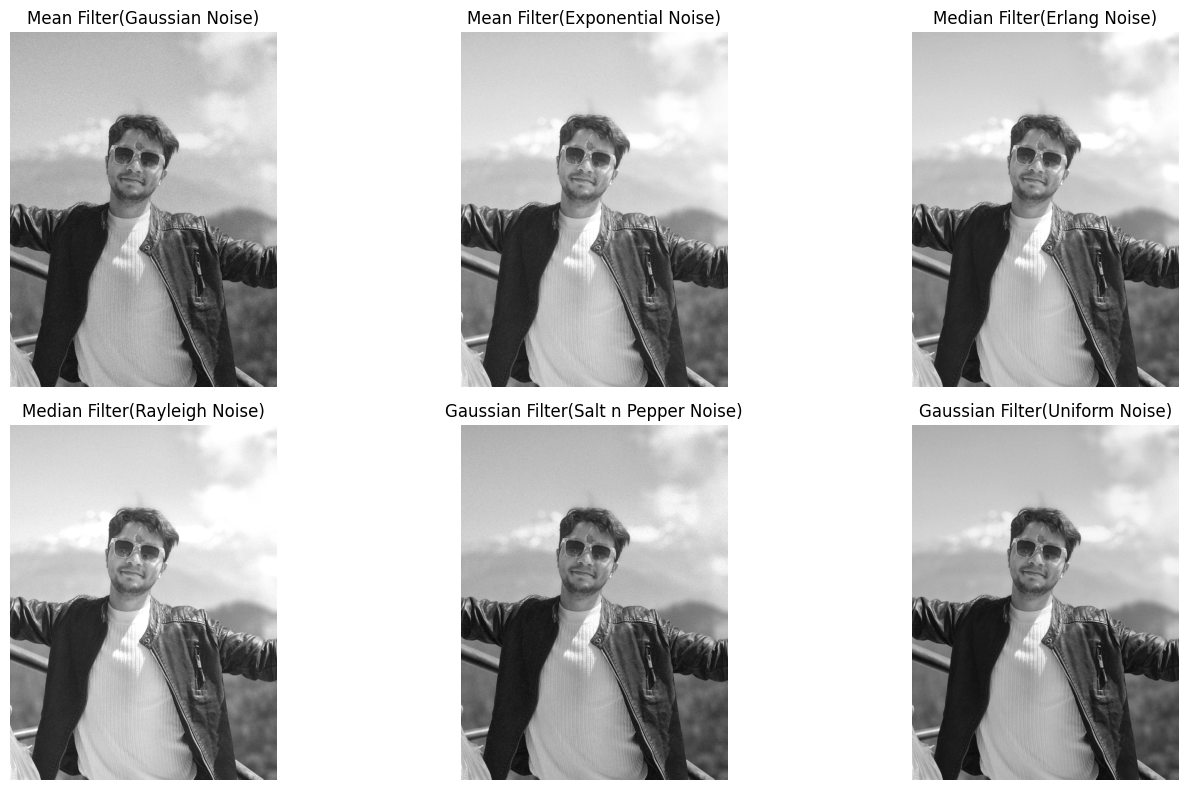

In [4]:
def apply_restoration_filter(imgs, kernel = 3, sigma = 1):
    filters = imgs
    for i in range(2):
        filters[i] = cv2.blur(imgs[i], (kernel, kernel))
        filters[2+i] = cv2.medianBlur(imgs[2 + i], kernel)
        filters[4+i] = cv2.GaussianBlur(imgs[4 + i], (kernel, kernel), sigma)
    return filters

titles = ["Mean Filter(Gaussian Noise)", "Mean Filter(Exponential Noise)", 
          "Median Filter(Erlang Noise)", "Median Filter(Rayleigh Noise)",
            "Gaussian Filter(Salt n Pepper Noise)", "Gaussian Filter(Uniform Noise)"]

imgs = [gauss, expo, erlang, rayleigh, sp, uniform]
filters = apply_restoration_filter(imgs)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(filters[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Compression using Huffman Encoding, Decoding, Run Length COding. Lossy and Lossless compressions

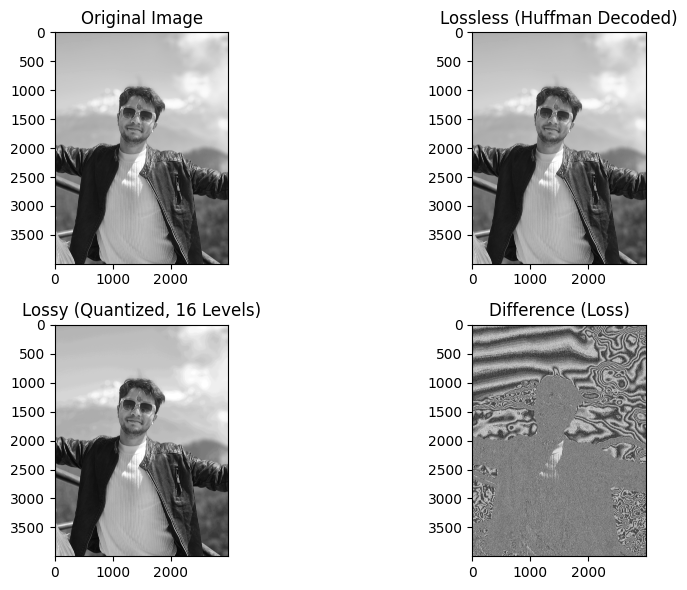

Original pixels: 12000000
Huffman encoded bits: 91700622 bits
Run Length encoded runs: 9265507 runs


In [5]:
import heapq
from collections import Counter, namedtuple

class Node(namedtuple("Node", ["left", "right"])):
    def walk(self, code, acc):
        self.left.walk(code, acc + "0")
        self.right.walk(code, acc + "1")

class Leaf(namedtuple("Leaf", ["char"])):
    def walk(self, code, acc):
        code[self.char] = acc or "0"

def huffman_encode(data):
    if len(set(data)) ==1:
        return {data[0]: "0"}, "0" * len(data)
    
    freq = Counter(data)
    heap = []
    for char, freq in freq.items():
        heap.append((freq, len(heap), Leaf(char)))
    heapq.heapify(heap)
    count = len(heap)
    while len(heap) > 1:
        freq1, _count1, left = heapq.heappop(heap)
        freq2, _count2, right = heapq.heappop(heap)
        heapq.heappush(heap, (freq1 + freq2, count, Node(left, right)))
        count += 1
    code = {}
    if heap:
        [(_, _count, root)] = heap
        root.walk(code, "")
    
    encoded_data = ''.join(code[char] for char in data)
    return code, encoded_data

def huffman_decode(encoded_data, code):
    if not encoded_data or not code:
        return []
    
    reverse_table = {codes: char for char, codes in code.items()}
    decoded = []
    current_code = ""

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_table:
            decoded.append(reverse_table[current_code])
            current_code = ""
    return decoded

def rl_encode(flat):
    
    encode = []
    prev_pix = flat[0]
    count = 1

    for pixel in flat[1: ]:
        if pixel == prev_pix:
            count += 1
        else:
            encode.append((prev_pix, count))
            prev_pix = pixel
            count = 1
    encode.append((prev_pix, count))
    return encode

def lossy_quantized(img, levels = 32):
    factor = 256 // levels
    return (img // factor) * factor

# Example with image flattened data
flat = img.flatten()
codes, encoded = huffman_encode(flat)
decoded = np.array(huffman_decode(encoded, codes), 
                   dtype=np.uint8).reshape(img.shape)
encode = rl_encode(flat)

lossy_img = lossy_quantized(img)
plt.figure(figsize=(10,6))
plt.subplot(2,2,1), plt.imshow(img, cmap='gray'), plt.title("Original Image")
plt.subplot(2,2,2), plt.imshow(decoded, cmap='gray')
plt.title("Lossless (Huffman Decoded)")
plt.subplot(2,2,3), plt.imshow(lossy_img, cmap='gray')
plt.title("Lossy (Quantized, 16 Levels)")
plt.subplot(2,2,4), plt.imshow(cv2.absdiff(img, lossy_img), cmap='gray')
plt.title("Difference (Loss)")
plt.tight_layout()
plt.show()

print(f"Original pixels: {flat.size}")
print(f"Huffman encoded bits: {len(encoded)} bits")
print(f"Run Length encoded runs: {len(encode)} runs")